# Arizona 2020 General ERJ
**Additional Election Results Joined to VEST's Precinct Shapefile**

## Notes from VEST's Documentation File:

Election results from Arizona Secretary of State (https://azsos.gov/2020-election-information)
Precinct shapefile from Arizona Secretary of State via personal communication except Greenlee County is sourced from the county shapefile instead.

The following modifications were made to match the precinct boundaries for the 2020 general election.

Apache: Merge Puerco East/West

La Paz: Merge Alamo into Wenden

Maricopa: Merge South Mtn Park E, NE, S, SE, SW into South Mtn Park

- G20PRERTRU - Donald J. Trump (Republican Party)
- G20PREDBID - Joseph R. Biden (Democratic Party)
- G20PRELJOR - Jo Jorgensen (Libertarian Party)
- G20USSDKEL - Mark Kelly (Democratic Party)
- G20USSRMCS - Martha McSally (Republican Party)


## Notes on source precinct shapefile file from PDV notebook
VEST does not specify their shapefile source.

The VEST shapefile is the same as the 2018 one from Garrett Archer, except in 17 precincts, where 8 of those 17 precincts are the ones from Grenlee County that VEST subbed in with the county shapefile. [see validation script]

The RDH determined that we will not attempt to validate the VEST 2020 shapefile against the 2018 file from Garrett Archer, because we do not know if the 2018 file is an accurate representation of the geographies of precincts at the time of the 2020 election. We reached out to Garrett Archer on 6/14/2021 to see if he has the 2020 file and did not hear back as of 6/29/2021. 

In [1]:
import xml.etree.ElementTree as Xet
import pandas as pd
import numpy as np
import geopandas as gp
import os
pd.set_option("display.max_columns", None)

# VEST Precinct Shapefile

## Load VEST's Final File - processed election results

In [2]:
vest_shp = gp.read_file("./raw-from-source/VEST/az_2020/az_2020.shp")
vest_shp.shape

(1489, 9)

In [3]:
vest_shp.head(1)

,CDE_COUNTY,PCTNUM,PRECINCTNA,G20PREDBID,G20PRERTRU,G20PRELJOR,G20USSDKEL,G20USSRMCS,geometry
0,AP,AP0002,ALPINE,94,283,5,98,284,"POLYGON ((-109.49567 33.65280, -109.49576 33.6..."


<AxesSubplot:>

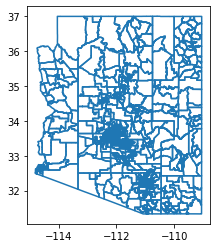

In [4]:
vest_shp.boundary.plot()

# SOS Election Results

NOTE FROM PDV NOTEBOOK: Running the cell below initially gave the following error: `IOPub data rate exceeded. The Jupyter server will temporarily stop sending output to the client in order to avoid crashing it.`

To fix this, run the jupyter notebook from terminal with: 
`jupyter notebook --NotebookApp.iopub_data_rate_limit=1.0e10` or `jupyter-lab --NotebookApp.iopub_data_rate_limit=1e10
`

## Load in all general election results from SOS as df

In [5]:
##GENERAL
## Converting Election Results XML
cols = ["contest", "participatingJurisdictions", "choice", "precinct", "voteType"]
rows = []
  
xmlparse = Xet.parse('./raw-from-source/SOS/Results.Detail_2020General.xml')
root = xmlparse.getroot()

data = []
lower = root.findall(".//contest")
for i in lower:
    contest = i.attrib.get('contestLongName')
    lower1 = i.findall('.//choice')
    for j in lower1:
        choice = j.attrib.get('choiceName')
        party = j.attrib.get('party')
        total_votes = j.attrib.get('totalVotes')
        is_write_in = j.attrib.get('isWriteIn')
        lower2 = j.findall('.//jurisdiction')
        for k in lower2:
            jurisdiction_key = k.attrib.get('key')
            jurisdiction_name = k.attrib.get('name')
            jurisdiction_total = k.attrib.get('votes')
            lower3 = k.findall('.//precinct')
            for l in lower3:
                precinct_key = l.attrib.get('key')
                precinct_name = l.attrib.get('name')
                precinct_votes = l.attrib.get('votes')
                data.append([contest, choice, party, total_votes, is_write_in, jurisdiction_key, jurisdiction_name, jurisdiction_total, 
                                 precinct_key, precinct_name, precinct_votes])

dfcols = ['contest','choice','party','total_votes','is_write_in','jurisdiction_key','jurisdiction_name','jurisdiction_total',
          'precinct_key','precinct_name','precinct_votes']
df = pd.DataFrame(data,columns=dfcols)

#Convert votes to int so numbers can be compared as numbers
df["precinct_votes"]=df["precinct_votes"].astype(int)

#Cut out judge elections + supreme court for now For simplicity - not congressional or state legislative + many options
df = df[~df['contest'].map(lambda x: ('Judge of the Court of Appeals  Division' in x)|('Judge of the Court of Appeals' in x)|('Supreme Court' in x))]

## Add district numbers to general election df + create district-precinct ids
Note this district splitting was not an issue in the initial round of PDV because sldl, sldu and usreps were not included
</br>Be careful to make sure votes properly distributed/split!

In [7]:
#Add district # as column to identify US House, State House/Senate districts where appropriate
#state senator
df['sldu_dist'] = 'NA'
df.loc[df['contest'].map(lambda x: ('District' in x)&('State Senator' in x)), 'sldu_dist'] = df.loc[df['contest'].map(lambda x: ('District' in x)&('State Senator' in x)),'contest'].str.slice(start = -2)
#state representative
df['sldl_dist'] = 'NA'
df.loc[df['contest'].map(lambda x: ('District' in x)&('State Representative' in x)), 'sldl_dist'] = df.loc[df['contest'].map(lambda x: ('District' in x)&('State Representative' in x)),'contest'].str.slice(start = -2)
#state leg combined into 1 col
df.loc[df['sldl_dist']=='NA', 'sldl_dist'] = df['sldu_dist']
df.loc[df['sldu_dist']=='NA', 'sldu_dist'] = df['sldl_dist']
df['SL_DIST'] = df['sldu_dist'].str.replace(' ', '0').str.zfill(2)

#US House
df['usrep_dist'] = 'NA'
df.loc[df['contest'].map(lambda x: ('District' in x)&('U.S. Representative' in x)), 'usrep_dist'] = df.loc[df['contest'].map(lambda x: ('District' in x)&('U.S. Representative' in x)), 'contest'].str.slice(start = -2)

#Create column header prefix based on contest
df['contest_formatted'] = '0'
df.loc[df['contest'].map(lambda x: ('U.S. Representative in Congress' in x)), 'contest_formatted'] = 'G20HOR'
df.loc[df['contest'].map(lambda x: ('U.S. Senator' in x)), 'contest_formatted'] = 'G20USS'
df.loc[df['contest'].map(lambda x: ('President' in x)), 'contest_formatted'] = 'G20PRE'
df.loc[df['contest'].map(lambda x: ('State Representative' in x)), 'contest_formatted'] = 'GSLL' #State Legislative Lower
df.loc[df['contest'].map(lambda x: ('State Senator' in x)), 'contest_formatted'] = 'GSLU' #Senate of Arizona - State Legislative Upper
df.loc[df['contest'].map(lambda x: ('Proposition' in x)), 'contest_formatted'] = 'G20PRO' # add 207 vs 208 to party
df.loc[df['contest'].map(lambda x: ('Corporation' in x)), 'contest_formatted'] = 'G20COC'

#CREATING PRECINCT - DISTRICT IDENTIFIER
#Create column with precinct-district id for sldl, sldu and usrep
df['prec_sldl_id_og'] = df['precinct_key'][df['sldl_dist']!='NA'] + '-'+df['sldl_dist'][df['sldl_dist']!='NA']
df['prec_sldu_id_og'] = df['precinct_key'][df['sldu_dist']!='NA'] + '-'+df['sldu_dist'][df['sldu_dist']!='NA']
df['prec_usrep_id_og'] = df['precinct_key'][df['usrep_dist']!='NA'] + '-'+df['usrep_dist'][df['usrep_dist']!='NA']
#Dictionary precinct_key: precinct_key with district
sldl_prec_key_dict = {value : key for (key, value) in pd.Series(df['precinct_key'].values, index = df['prec_sldl_id_og']).to_dict().items()}
sldu_prec_key_dict = {value : key for (key, value) in pd.Series(df['precinct_key'].values, index = df['prec_sldu_id_og']).to_dict().items()}
usrep_prec_key_dict = {value : key for (key, value) in pd.Series(df['precinct_key'].values, index = df['prec_usrep_id_og']).to_dict().items()}
#Create column for entire df with given district numbers
df['prec_sldl_id_toall'] = df['precinct_key'].map(sldl_prec_key_dict)
df['prec_sldu_id_toall'] = df['precinct_key'].map(sldu_prec_key_dict)
df['prec_usrep_id_toall'] = df['precinct_key'].map(usrep_prec_key_dict)
#Create column with single identifier with district numbers for every office
df['prec_id_sldl_sldu_usrep'] = '['+df['prec_sldl_id_toall']+']['+df['prec_sldu_id_toall']+']['+df['prec_usrep_id_toall']+']'

## Create column for field names to be used when results pivoted based on contest 

In [8]:
#Add candidate names as appropriate and create field IDs
df.loc[df['contest'].map(lambda x: ('U.S. Senator' in x)|('Supreme Court' in x)|('President' in x)|('Corporation' in x)), 'field_id'] = df['contest_formatted'] + df['party'].str.slice(stop = 1) + df['choice'].map(lambda x: "".join(filter(str.isalnum, x))).str.upper().str.slice(stop = 3)
df.loc[df['contest'].map(lambda x: ('Proposition' in x)), 'field_id'] = df['contest_formatted'] + df['contest'].str.slice(start = -3) + df['choice'].map(lambda x: "".join(filter(str.isalnum, x))).str.upper().str.slice(stop = 1)
df.loc[df['contest'].map(lambda x: ('U.S. Representative in Congress' in x)|('State Representative' in x)|('State Senator' in x)), 'field_id'] = df['contest_formatted'] + df['party']
df.loc[df['contest'].map(lambda x: ('State Representative' in x)|('State Senator' in x)), 'field_id'] = df['contest_formatted'] + df['party'].str.slice(stop = 1) + df['SL_DIST'].map(lambda x: "".join(filter(str.isalnum, x)))+ df['choice'].map(lambda x: "".join(filter(str.isalnum, x))).str.upper().str.slice(stop = 3)


In [9]:
df.head(1)

,contest,choice,party,total_votes,is_write_in,jurisdiction_key,jurisdiction_name,jurisdiction_total,precinct_key,precinct_name,precinct_votes,sldu_dist,sldl_dist,SL_DIST,usrep_dist,contest_formatted,prec_sldl_id_og,prec_sldu_id_og,prec_usrep_id_og,prec_sldl_id_toall,prec_sldu_id_toall,prec_usrep_id_toall,prec_id_sldl_sldu_usrep,field_id
0,President of the United States,"Biden, Joseph",DEM,1672143,false,1,Apache,23293,9179,02 ALPINE,94,NA,NA,NA,NA,G20PRE,NaN,NaN,NaN,9179- 7,9179- 7,9179- 1,[9179- 7][9179- 7][9179- 1],G20PREDBID


In [10]:
(df['prec_id_sldl_sldu_usrep']).nunique()

1489

In [11]:
(df['precinct_key'][df['sldl_dist']!='NA'] + '-'+df['sldl_dist'][df['sldl_dist']!='NA']).nunique()

1489

In [12]:
(df['precinct_key'][df['usrep_dist']!='NA'] + '-'+df['usrep_dist'][df['usrep_dist']!='NA']).nunique()

1489

## Check out districts

In [13]:
state_leg_df = df[(df['contest_formatted']=='GSLL')|(df['contest_formatted']=='GSLU')]

#Set state leg districts
state_leg_df.loc[state_leg_df['sldl_dist']=='NA', 'sldl_dist'] = state_leg_df['sldu_dist']
state_leg_df.loc[state_leg_df['sldu_dist']=='NA', 'sldu_dist'] = state_leg_df['sldl_dist']
state_leg_df['SL_DIST'] = state_leg_df['sldu_dist'].str.replace(' ', '0').str.zfill(2)

#Set field id for state leg candidates
state_leg_df['leg_field_id'] = state_leg_df['contest_formatted'] + state_leg_df['party'].str.slice(stop = 1) + state_leg_df['SL_DIST']+ state_leg_df['choice'].map(lambda x: "".join(filter(str.isalnum, x))).str.upper().str.slice(stop = 3)

#pivot state leg results
state_leg_pivot = pd.pivot_table(state_leg_df, index = ['jurisdiction_name', 'precinct_name', 'SL_DIST', 'prec_id_sldl_sldu_usrep'], 
                             columns = ['leg_field_id'], 
                             values = ['precinct_votes'], 
                             aggfunc = np.sum)
state_leg_pivot

<ipython-input-13-9514a774886c>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  state_leg_df['SL_DIST'] = state_leg_df['sldu_dist'].str.replace(' ', '0').str.zfill(2)
<ipython-input-13-9514a774886c>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  state_leg_df['leg_field_id'] = state_leg_df['contest_formatted'] + state_leg_df['party'].str.slice(stop = 1) + state_leg_df['SL_DIST']+ state_leg_df['choice'].map(lambda x: "".join(filter(str.isalnum, x))).str.upper().str.slice(stop = 3)


precinct_votes  \
leg_field_id                                                                     GSLLA18WIL   
jurisdiction_name precinct_name       SL_DIST prec_id_sldl_sldu_usrep                         
Apache            02 ALPINE           07      [9179- 7][9179- 7][9179- 1]               NaN   
                  03 CANYON DE CHELLY 07      [9180- 7][9180- 7][9180- 1]               NaN   
                  05 CHINLE           07      [9181- 7][9181- 7][9181- 1]               NaN   
                  09 CONCHO           07      [9182- 7][9182- 7][9182- 1]               NaN   
                  10 CORNFIELDS       07      [9183- 7][9183- 7][9183- 1]               NaN   
...                                                                                     ...   
Yuma              PRECINCT 040        04      [10618- 4][10618- 4][10618- 3]            NaN   
                  PRECINCT 041        04      [10619- 4][10619- 4][10619- 3]            NaN   
                  PRECINCT 042        13      [10620-13][10620-13][10620- 3]            NaN   
                  PRECINCT 043        13      [10621-13][10621-13][10621- 3]            NaN   
                  PRECINCT 044        04      [10622- 4][10622- 4][10622- 3]            NaN   

                                                                                         \
leg_field_id                                                                 GSLLD01STA   
jurisdiction_name precinct_name       SL_DIST prec_id_sldl_sldu_usrep                     
Apache            02 ALPINE           07      [9179- 7][9179- 7][9179- 1]           NaN   
                  03 CANYON DE CHELLY 07      [9180- 7][9180- 7][9180- 1]           NaN   
                  05 CHINLE           07      [9181- 7][9181- 7][9181- 1]           NaN   
                  09 CONCHO           07      [9182- 7][9182- 7][9182- 1]           NaN   
                  10 CORNFIELDS       07      [9183- 7][9183- 7][9183- 1]           NaN   
...                                                                                 ...   
Yuma              PRECINCT 040        04      [10618- 4][10618- 4][10618- 3]        NaN   
                  PRECINCT 041        04      [10619- 4][10619- 4][10619- 3]        NaN   
                  PRECINCT 042        13      [10620-13][10620-13][10620- 3]        NaN   
                  PRECINCT 043        13      [10621-13][10621-13][10621- 3]        NaN   
                  PRECINCT 044        04      [10622- 4][10622- 4][10622- 3]        NaN   

                                                                                         \
leg_field_id                                                                 GSLLD02DAL   
jurisdiction_name precinct_name       SL_DIST prec_id_sldl_sldu_usrep                     
Apache            02 ALPINE           07      [9179- 7][9179- 7][9179- 1]           NaN   
                  03 CANYON DE CHELLY 07      [9180- 7][9180- 7][9180- 1]           NaN   
                  05 CHINLE           07      [9181- 7][9181- 7][9181- 1]           NaN   
                  09 CONCHO           07      [9182- 7][9182- 7][9182- 1]           NaN   
                  10 CORNFIELDS       07      [9183- 7][9183- 7][9183- 1]           NaN   
...                                                                                 ...   
Yuma              PRECINCT 040        04      [10618- 4][10618- 4][10618- 3]        NaN   
                  PRECINCT 041        04      [10619- 4][10619- 4][10619- 3]        NaN   
                  PRECINCT 042        13      [10620-13][10620-13][10620- 3]        NaN   
                  PRECINCT 043        13      [10621-13][10621-13][10621- 3]        NaN   
                  PRECINCT 044        04      [10622- 4][10622- 4][10622- 3]        NaN   

                                                                                         \
leg_field_id                                                                 GSLLD02HER   
jurisdiction_n

In [14]:
#rename columns/reset to formate
state_leg_pivot.columns = state_leg_pivot.columns.to_series().str.join(' ')
state_leg_pivot = state_leg_pivot.fillna(0)
state_leg_pivot.reset_index(inplace=True)
state_leg_pivot.columns = state_leg_pivot.columns.map(lambda x : x if 'precinct_votes ' not in x else  x[len('precinct_votes '):])
state_leg_pivot.head()

,jurisdiction_name,precinct_name,SL_DIST,prec_id_sldl_sldu_usrep,GSLLA18WIL,GSLLD01STA,GSLLD02DAL,GSLLD02HER,GSLLD03CAN,GSLLD03HER,GSLLD04FER,GSLLD04PET,GSLLD06EVA,GSLLD07TEL,GSLLD07TSO,GSLLD08GIR,GSLLD08LES,GSLLD09FRI,GSLLD09POW,GSLLD10DEG,GSLLD10STA,GSLLD11PER,GSLLD12CLA,GSLLD13SAN,GSLLD14BEA,GSLLD14HAM,GSLLD14MAE,GSLLD15DYB,GSLLD16HUN,GSLLD17PAW,GSLLD18EPS,GSLLD18JER,GSLLD19ESP,GSLLD19QUI,GSLLD19SIE,GSLLD20SCH,GSLLD21KNE,GSLLD22GAR,GSLLD22HON,GSLLD23KUR,GSLLD24LON,GSLLD24SHA,GSLLD25HUG,GSLLD26HER,GSLLD26SAL,GSLLD27BOL,GSLLD27ROD,GSLLD28BUT,GSLLD28LIE,GSLLD29AND,GSLLD29CHA,GSLLD30MEZ,GSLLD30TER,GSLLI06BAB,GSLLR01BUR,GSLLR01NGU,GSLLR02MCE,GSLLR04JOH,GSLLR05BIA,GSLLR05COB,GSLLR06BAR,GSLLR06BLA,GSLLR07PAR,GSLLR07PEE,GSLLR07WIS,GSLLR08COO,GSLLR08PRA,GSLLR09LYO,GSLLR10GUM,GSLLR10HIC,GSLLR11FIN,GSLLR11MUR,GSLLR11ROB,GSLLR12GRA,GSLLR12HOF,GSLLR13DUN,GSLLR13OSB,GSLLR14GRI,GSLLR14NUT,GSLLR15KAI,GSLLR15WIL,GSLLR16FIL,GSLLR16PAR,GSLLR17HAR,GSLLR17WEN,GSLLR18HAW,GSLLR18ROB,GSLLR20BOL,GSLLR20KER,GSLLR21PAY,GSLLR21PIN,GSLLR22CAR,GSLLR22TOM,GSLLR23CHA,GSLLR23KAV,GSLLR23ROM,GSLLR24ALG,GSLLR24CUS,GSLLR25BOW,GSLLR25UDA,GSLLR26LOU,GSLLR26SIF,GSLLR27PEÑ,GSLLR28BOW,GSLLR28JAC,GSLLR29BRA,GSLLR29FOK,GSLUD01CAR,GSLUD02GAB,GSLUD03GON,GSLUD04OTO,GSLUD05MUR,GSLUD05SCH,GSLUD06FRE,GSLUD07PES,GSLUD08MCG,GSLUD09STE,GSLUD10ENG,GSLUD11MEN,GSLUD12ROB,GSLUD14KAR,GSLUD16GRA,GSLUD17KUR,GSLUD18BOW,GSLUD19CHA,GSLUD20ERV,GSLUD22TYR,GSLUD23BLA,GSLUD24ALS,GSLUD25WEI,GSLUD26MEN,GSLUD27RIO,GSLUD28MAR,GSLUD29QUE,GSLUD30NAV,GSLUI16FIE,GSLUI16HAR,GSLUL15SMI,GSLUL23KIR,GSLUL29CAR,GSLUR01FAN,GSLUR02WOR,GSLUR04ANG,GSLUR05BOR,GSLUR06ROG,GSLUR08SHO,GSLUR10WAD,GSLUR11LEA,GSLUR12PET,GSLUR13BAC,GSLUR13KER,GSLUR14GOW,GSLUR15BAR,GSLUR16TOW,GSLUR17MES,GSLUR18SHA,GSLUR20BOY,GSLUR21GRA,GSLUR22LIV,GSLUR23UGE,GSLUR24MIC,GSLUR25PAC,GSLUR26CHI,GSLUR27SHR,GSLUR28BRO,GSLUR29WIL
0,Apache,02 ALPINE,07,[9179- 7][9179- 7][9179- 1],0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,81.0,87.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,252.0,251.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,145.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Apache,03 CANYON DE CHELLY,07,[9180- 7][9180- 7][9180- 1],0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1504.0,1700.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,133.0,156.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2127.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Apache,05 CHINLE,07,[9181- 7][9181- 7][9181- 1],0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,748.0,876.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,92.0,93.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1066.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Apache,09 CONCHO,

In [15]:
#Check district result
for col in state_leg_pivot[state_leg_pivot['SL_DIST']=='01'].columns:
    if (state_leg_pivot[col][state_leg_pivot['SL_DIST']=='01'].sum() != 0):
        print(col, state_leg_pivot[col][state_leg_pivot['SL_DIST']=='01'].sum())

jurisdiction_name MaricopaMaricopaMaricopaMaricopaMaricopaMaricopaMaricopaMaricopaMaricopaMaricopaMaricopaMaricopaMaricopaMaricopaMaricopaMaricopaYavapaiYavapaiYavapaiYavapaiYavapaiYavapaiYavapaiYavapaiYavapaiYavapaiYavapaiYavapaiYavapaiYavapaiYavapaiYavapaiYavapaiYavapaiYavapaiYavapaiYavapaiYavapaiYavapaiYavapaiYavapaiYavapaiYavapaiYavapaiYavapaiYavapaiYavapaiYavapaiYavapaiYavapaiYavapai
precinct_name 0049 BISCUIT FLAT0086 CAREFREE0096 CAVE CREEK0113 CLAY MINE0168 DEADMAN WASH0180 DESERT HILLS0196 DOVE VALLEY0250 GAVILAN PEAK0292 HASTINGS0395 MAJESTY0444 NEW RIVER0527 RANCHO PALOMA0625 SPUR CROSS0662 TABLE MESA0677 TRAMONTO0741 WOLF RUNBASIN (237.00)BIGHORN (245.00)BISON (244.00)BUCK (215.00)BUG (222.00)BURRO (243.00)CAMP (236.00)CARS (240.00)COURT (202.00)COYOTE (239.00)EAGLE (201.00)FAIR (203.00)GOLF (204.00)GRAZE (238.00)HILL (206.00)IRON (225.00)KIRK (214.00)MESQUITE (207.00)MINE (205.00)PLEASANT (212.00)QUAIL (231.00)RANCH (235.00)RIM (220.00)SALT (221.00)SKULL (213.00)SPIRIT (22

Notice that now only representatives in district 1 have votes, as we'd hope.
</br> See that `GSLUR` has the most votes followed by `GSLLR`, then `GSLLR` followed by the two democrats. 
</br> If we were to separate it into the top two candidates by party for each district and a user wanted to figure out which candidate was represented by the variable, they would need to check the district, then match the precinct or district vote count and check against an external source... This seems more complicated than just laying it out clearly in the df to me. 


## Pivot gernal election results

### Checks

In [16]:
# Jurisdiction (County) key and values map one to one: (can use either one for pivot)
(df.jurisdiction_key.value_counts().values == df.jurisdiction_name.value_counts().values).all()

True

In [17]:
# Precinct key and values map one to one: (can use either one for pivot)
(df.precinct_key.value_counts().values == df.precinct_name.value_counts().values).all()

True

In [18]:
# Precinct key and prec_district_ids map one to one: (can use either one for pivot)
(df.precinct_key.value_counts().values == df.prec_id_sldl_sldu_usrep.value_counts().values).all()

True

In [19]:
df.field_id.value_counts().sum()

70978

### Pivot

In [20]:
prec_row_df = pd.pivot_table(df, index = ['jurisdiction_name', 'precinct_name', 'prec_id_sldl_sldu_usrep'], 
                             columns = ['field_id'], 
                             values = ['precinct_votes'], 
                             aggfunc = np.sum)
prec_row_df

precinct_votes  \
field_id                                                                 G20COCDMUN   
jurisdiction_name precinct_name       prec_id_sldl_sldu_usrep                         
Apache            02 ALPINE           [9179- 7][9179- 7][9179- 1]              91.0   
                  03 CANYON DE CHELLY [9180- 7][9180- 7][9180- 1]            1213.0   
                  05 CHINLE           [9181- 7][9181- 7][9181- 1]             639.0   
                  09 CONCHO           [9182- 7][9182- 7][9182- 1]             305.0   
                  10 CORNFIELDS       [9183- 7][9183- 7][9183- 1]             255.0   
...                                                                             ...   
Yuma              PRECINCT 040        [10618- 4][10618- 4][10618- 3]          529.0   
                  PRECINCT 041        [10619- 4][10619- 4][10619- 3]          608.0   
                  PRECINCT 042        [10620-13][10620-13][10620- 3]          740.0   
                  PRECINCT 043        [10621-13][10621-13][10621- 3]            9.0   
                  PRECINCT 044        [10622- 4][10622- 4][10622- 3]            0.0   

                                                                                 \
field_id                                                             G20COCDSTA   
jurisdiction_name precinct_name       prec_id_sldl_sldu_usrep                     
Apache            02 ALPINE           [9179- 7][9179- 7][9179- 1]          76.0   
                  03 CANYON DE CHELLY [9180- 7][9180- 7][9180- 1]        1329.0   
                  05 CHINLE           [9181- 7][9181- 7][9181- 1]         611.0   
                  09 CONCHO           [9182- 7][9182- 7][9182- 1]         260.0   
                  10 CORNFIELDS       [9183- 7][9183- 7][9183- 1]         282.0   
...                                                                         ...   
Yuma              PRECINCT 040        [10618- 4][10618- 4][10618- 3]      489.0   
                  PRECINCT 041        [10619- 4][10619- 4][10619- 3]      593.0   
                  PRECINCT 042        [10620-13][10620-13][10620- 3]      721.0   
                  PRECINCT 043        [10621-13][10621-13][10621- 3]        9.0   
                  PRECINCT 044        [10622- 4][10622- 4][10622- 3]        0.0   

                                                                                 \
field_id                                                             G20COCDTOV   
jurisdiction_name precinct_name       prec_id_sldl_sldu_usrep                     
Apache            02 ALPINE           [9179- 7][9179- 7][9179- 1]          86.0   
                  03 CANYON DE CHELLY [9180- 7][9180- 7][9180- 1]        1322.0   
                  05 CHINLE           [9181- 7][9181- 7][9181- 1]         720.0   
                  09 CONCHO           [9182- 7][9182- 7][9182- 1]         318.0   
                  10 CORNFIELDS       [9183- 7][9183- 7][9183- 1]         260.0   
...                                                                         ...   
Yuma              PRECINCT 040        [10618- 4][10618- 4][10618- 3]      666.0   
                  PRECINCT 041        [10619- 4][10619- 4][10619- 3]      841.0   
                  PRECINCT 042        [10620-13][10620-13][10620- 3]     1061.0   
                  PRECINCT 043        [10621-13][10621-13][10621- 3]       12.0   
                  PRECINCT 044        [10622- 4][10622- 4][10622- 3]        0.0   

                                                                                 \
field_id                                                             G20COCIGIB   
jurisdiction_name precinct_name       prec_id_sldl_sldu_usrep                     
Apache            02 ALPINE           [9179- 7][9179- 7][9179- 1]           0.0   
                  03 CANYON DE CHELLY [9180- 7][9180- 7][9180- 1]           0.0   
                  05 CHINLE           [9181- 7][9181- 7][9181- 1]           0.0   
                  09 CONCH

In [21]:
#rename columns
prec_row_df.columns = prec_row_df.columns.to_series().str.join(' ')
prec_row_df = prec_row_df.fillna(0)
prec_row_df.reset_index(inplace=True)
prec_row_df.columns = prec_row_df.columns.map(lambda x : x if 'precinct_votes ' not in x else  x[len('precinct_votes '):])
prec_row_df.head()

,jurisdiction_name,precinct_name,prec_id_sldl_sldu_usrep,G20COCDMUN,G20COCDSTA,G20COCDTOV,G20COCIGIB,G20COCRFIN,G20COCRMAR,G20COCROCO,G20COCRSLO,G20HORCSM,G20HORDEM,G20HORIND,G20HORLBT,G20HORREP,G20PREACUM,G20PREDBID,G20PREGHAW,G20PRELJOR,G20PRENBOD,G20PRENSIM,G20PREPLAR,G20PRERTRU,G20PRO207N,G20PRO207Y,G20PRO208N,G20PRO208Y,G20USSDARI,G20USSDCHI,G20USSDKAP,G20USSDKEL,G20USSDSTE,G20USSIBEC,G20USSIDEC,G20USSIGLE,G20USSIHAU,G20USSIROD,G20USSISAE,G20USSLDOR,G20USSNSTE,G20USSRDAV,G20USSRMCS,G20USSRSCH,G20USSRSIM,G20USSRTHO,G20USSUROD,GSLLA18WIL,GSLLD01STA,GSLLD02DAL,GSLLD02HER,GSLLD03CAN,GSLLD03HER,GSLLD04FER,GSLLD04PET,GSLLD06EVA,GSLLD07TEL,GSLLD07TSO,GSLLD08GIR,GSLLD08LES,GSLLD09FRI,GSLLD09POW,GSLLD10DEG,GSLLD10STA,GSLLD11PER,GSLLD12CLA,GSLLD13SAN,GSLLD14BEA,GSLLD14HAM,GSLLD14MAE,GSLLD15DYB,GSLLD16HUN,GSLLD17PAW,GSLLD18EPS,GSLLD18JER,GSLLD19ESP,GSLLD19QUI,GSLLD19SIE,GSLLD20SCH,GSLLD21KNE,GSLLD22GAR,GSLLD22HON,GSLLD23KUR,GSLLD24LON,GSLLD24SHA,GSLLD25HUG,GSLLD26HER,GSLLD26SAL,GSLLD27BOL,GSLLD27ROD,GSLLD28BUT,GSLLD28LIE,GSLLD29AND,GSLLD29CHA,GSLLD30MEZ,GSLLD30TER,GSLLI06BAB,GSLLR01BUR,GSLLR01NGU,GSLLR02MCE,GSLLR04JOH,GSLLR05BIA,GSLLR05COB,GSLLR06BAR,GSLLR06BLA,GSLLR07PAR,GSLLR07PEE,GSLLR07WIS,GSLLR08COO,GSLLR08PRA,GSLLR09LYO,GSLLR10GUM,GSLLR10HIC,GSLLR11FIN,GSLLR11MUR,GSLLR11ROB,GSLLR12GRA,GSLLR12HOF,GSLLR13DUN,GSLLR13OSB,GSLLR14GRI,GSLLR14NUT,GSLLR15KAI,GSLLR15WIL,GSLLR16FIL,GSLLR16PAR,GSLLR17HAR,GSLLR17WEN,GSLLR18HAW,GSLLR18ROB,GSLLR20BOL,GSLLR20KER,GSLLR21PAY,GSLLR21PIN,GSLLR22CAR,GSLLR22TOM,GSLLR23CHA,GSLLR23KAV,GSLLR23ROM,GSLLR24ALG,GSLLR24CUS,GSLLR25BOW,GSLLR25UDA,GSLLR26LOU,GSLLR26SIF,GSLLR27PEÑ,GSLLR28BOW,GSLLR28JAC,GSLLR29BRA,GSLLR29FOK,GSLUD01CAR,GSLUD02GAB,GSLUD03GON,GSLUD04OTO,GSLUD05MUR,GSLUD05SCH,GSLUD06FRE,GSLUD07PES,GSLUD08MCG,GSLUD09STE,GSLUD10ENG,GSLUD11MEN,GSLUD12ROB,GSLUD14KAR,GSLUD16GRA,GSLUD17KUR,GSLUD18BOW,GSLUD19CHA,GSLUD20ERV,GSLUD22TYR,GSLUD23BLA,GSLUD24ALS,GSLUD25WEI,GSLUD26MEN,GSLUD27RIO,GSLUD28MAR,GSLUD29QUE,GSLUD30NAV,GSLUI16FIE,GSLUI16HAR,GSLUL15SMI,GSLUL23KIR,GSLUL29CAR,GSLUR01FAN,GSLUR02WOR,GSLUR04ANG,GSLUR05BOR,GSLUR06ROG,GSLUR08SHO,GSLUR10WAD,GSLUR11LEA,GSLUR12PET,GSLUR13BAC,GSLUR13KER,GSLUR14GOW,GSLUR15BAR,GSLUR16TOW,GSLUR17MES,GSLUR18SHA,GSLUR20BOY,GSLUR21GRA,GSLUR22LIV,GSLUR23UGE,GSLUR24MIC,GSLUR25PAC,GSLUR26CHI,GSLUR27SHR,GSLUR28BRO,GSLUR29WIL
0,Apache,02 ALPINE,[9179- 7][9179- 7][9179- 1],91.0,76.0,86.0,0.0,0.0,242.0,257.0,233.0,0.0,105.0,0.0,0.0,271.0,0.0,94.0,0.0,5.0,0.0,0.0,0.0,283.0,207.0,168.0,260.0,116.0,0.0,0.0,0.0,98.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,284.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,81.0,87.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,252.0,251.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,145.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Apache,03 CANYON DE CHELLY,[9180- 7][9180- 7][9180- 1],1213.0,1329.0,1322.0,0.0,0.0,174.0,210.0,196.0,0.0,1964.0,0.0,0.0,300.0,0.0,1982.0,0.0,30.0,0.0,0.0,0.0,273.0,1154.0,1010.0,726.0,1431.0,0.0,0.0,0.0,1995.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,290.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1504.0,1700.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,133.0,156.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2127.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,

In [22]:
#Assign district numbers to separate column
prec_row_df['SL_DIST'] = prec_row_df['prec_id_sldl_sldu_usrep'].str.slice(start = 6, stop = 8)
prec_row_df.loc[prec_row_df['prec_id_sldl_sldu_usrep'].str.startswith('[10'), 'SL_DIST'] = prec_row_df['prec_id_sldl_sldu_usrep'].str.slice(start = 7, stop = 9)
prec_row_df['SL_DIST'] = prec_row_df['SL_DIST'].str.replace(' ', '0').str.zfill(2)
prec_row_df['HOR_DIST'] = prec_row_df['prec_id_sldl_sldu_usrep'].str.slice(start = -3, stop = -1).str.replace(' ', '0').str.zfill(2)

In [23]:
#Check district result
for col in prec_row_df[prec_row_df['SL_DIST']=='01'].columns:
    if (prec_row_df[col][prec_row_df['SL_DIST']=='01'].sum() != 0)&('GSL' in col):
        print(col, prec_row_df[col][prec_row_df['SL_DIST']=='01'].sum())

GSLLD01STA 47204.0
GSLLR01BUR 92058.0
GSLLR01NGU 86405.0
GSLUD01CAR 40063.0
GSLUR01FAN 105712.0


Notice that now only representatives in district 1 have votes, as we'd hope.
</br> See that `GSLUR` has the most votes followed by `GSLLR`, then `GSLLR` followed by the two democrats. 
</br> If we were to separate it into the top two candidates by party for each district and a user wanted to figure out which candidate was represented by the variable, they would need to check the district, then match the precinct or district vote count and check against an external source... This seems more complicated than just laying it out clearly in the df to me. 


# Prepare to validate election results

## Add county fips to df and to VEST file

In [24]:
#Load in the nationwide FIPS file
fips_file = pd.read_csv("./raw-from-source/FIPS/US_FIPS_Codes.csv")
fips_file = fips_file[fips_file["State"]=="Arizona"]
fips_file["FIPS County"]=fips_file["FIPS County"].astype(str)

#Make the FIPS three digits
fips_file["FIPS County"]=fips_file["FIPS County"].str.zfill(3)

#Create the dictionary
az_fips_dict = dict(zip(fips_file["County Name"],fips_file["FIPS County"]))

prec_row_df['COUNTYFP'] = prec_row_df['jurisdiction_name'].apply(lambda x: az_fips_dict.get(x))

#FOR VEST FILE
#Map VEST county name abbreviations to county names
cde_county_dict = {'AP':'Apache', 'CH':'Cochise', 'CN':'Coconino', 'GI':'Gila', 'GM':'Graham', 'LP':'La Paz', 'MO':'Mohave', 'PN':'Pinal', 'SC':'Santa Cruz', 'YA':'Yavapai', 'NA':'Navajo',
       'YU':'Yuma', 'MC':'Maricopa', 'PM':'Pima', 'GN':'Greenlee'}

#Use above mapping to create county fips column
vest_shp['county_name'] = vest_shp['CDE_COUNTY'].apply(lambda x: cde_county_dict.get(x))
vest_shp['COUNTYFP'] = vest_shp['county_name'].apply(lambda x: az_fips_dict.get(x))

## Merge SOS Election Results and VEST's

In [25]:
vest_shp.shape

(1489, 11)

In [26]:
prec_row_df.shape

(1489, 212)

In [27]:
prec_row_df['precinct_name'].nunique()

1489

In [28]:
prec_row_df.columns

Index(['jurisdiction_name', 'precinct_name', 'prec_id_sldl_sldu_usrep',
       'G20COCDMUN', 'G20COCDSTA', 'G20COCDTOV', 'G20COCIGIB', 'G20COCRFIN',
       'G20COCRMAR', 'G20COCROCO',
       ...
       'GSLUR23UGE', 'GSLUR24MIC', 'GSLUR25PAC', 'GSLUR26CHI', 'GSLUR27SHR',
       'GSLUR28BRO', 'GSLUR29WIL', 'SL_DIST', 'HOR_DIST', 'COUNTYFP'],
      dtype='object', length=212)

**During validation for PDV, did join attempt 1, then wrote to shp, then matched below by hand**
</br>Notes: 
- Gila County (007): compare VEST P/S EAST and P/S WEST with SOS
- Graham County (009): need to use the PCTNUM to figure out the 3 SAFFORD precincts
</br>Lined up all of the precincts by hand and loaded back in as dictionary file. 

## Read in csv made during PDV to match counties and precincts for join

In [29]:
precinct_dictionary_csv = pd.read_csv('election_results_dictionary.csv', dtype = {'COUNTYFP_vest':'object','COUNTYFP_sos':'object'})
precinct_dictionary_csv.head()

,COUNTYFP_vest,PCTNUM_vest,PRECINCTNA_vest,G20PREDBID_vest,COUNTYFP_sos,precinct_name_sos,G20PREDBID_sos
0,001,AP0002,ALPINE,94,001,02 ALPINE,94
1,001,AP0003,CANYON DE CHELLY,1982,001,03 CANYON DE CHELLY,1982
2,001,AP0005,CHINLE,989,001,05 CHINLE,989
3,001,AP0009,CONCHO,333,001,09 CONCHO,333
4,001,AP0010,CORNFIELDS,393,001,10 CORNFIELDS,393


In [30]:
vest_shp_merged = vest_shp.merge(precinct_dictionary_csv, how = 'outer', left_on = ['PCTNUM'], 
                                                right_on = ['PCTNUM_vest'], indicator = True)
vest_shp_merged.groupby('_merge').count()

,CDE_COUNTY,PCTNUM,PRECINCTNA,G20PREDBID,G20PRERTRU,G20PRELJOR,G20USSDKEL,G20USSRMCS,geometry,county_name,COUNTYFP,COUNTYFP_vest,PCTNUM_vest,PRECINCTNA_vest,G20PREDBID_vest,COUNTYFP_sos,precinct_name_sos,G20PREDBID_sos
_merge,,,,,,,,,,,,,,,,,,
left_only,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
right_only,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
both,1489,1489,1489,1489,1489,1489,1489,1489,1489,1489,1489,1489,1489,1489,1489,1489,1489,1489


In [31]:
vest_shp_merged.shape

(1489, 19)

In [32]:
#Drop to enable join later on
vest_shp_merged.drop(columns = ['_merge'], inplace = True)

## Join vest df to processed SOS df

In [33]:
#df vest merged with updated pct names to join to sos
vest_shp_merged.columns

Index(['CDE_COUNTY', 'PCTNUM', 'PRECINCTNA', 'G20PREDBID', 'G20PRERTRU',
       'G20PRELJOR', 'G20USSDKEL', 'G20USSRMCS', 'geometry', 'county_name',
       'COUNTYFP', 'COUNTYFP_vest', 'PCTNUM_vest', 'PRECINCTNA_vest',
       'G20PREDBID_vest', 'COUNTYFP_sos', 'precinct_name_sos',
       'G20PREDBID_sos'],
      dtype='object')

In [34]:
df_joined_to_vest = vest_shp_merged.merge(prec_row_df, how = 'outer'
                            , left_on = ['COUNTYFP','precinct_name_sos'], right_on = ['COUNTYFP','precinct_name'], suffixes=('_x', '')
                            , indicator = True)

In [35]:
df_joined_to_vest.groupby('_merge').count()

,CDE_COUNTY,PCTNUM,PRECINCTNA,G20PREDBID_x,G20PRERTRU_x,G20PRELJOR_x,G20USSDKEL_x,G20USSRMCS_x,geometry,county_name,COUNTYFP,COUNTYFP_vest,PCTNUM_vest,PRECINCTNA_vest,G20PREDBID_vest,COUNTYFP_sos,precinct_name_sos,G20PREDBID_sos,jurisdiction_name,precinct_name,prec_id_sldl_sldu_usrep,G20COCDMUN,G20COCDSTA,G20COCDTOV,G20COCIGIB,G20COCRFIN,G20COCRMAR,G20COCROCO,G20COCRSLO,G20HORCSM,G20HORDEM,G20HORIND,G20HORLBT,G20HORREP,G20PREACUM,G20PREDBID,G20PREGHAW,G20PRELJOR,G20PRENBOD,G20PRENSIM,G20PREPLAR,G20PRERTRU,G20PRO207N,G20PRO207Y,G20PRO208N,G20PRO208Y,G20USSDARI,G20USSDCHI,G20USSDKAP,G20USSDKEL,G20USSDSTE,G20USSIBEC,G20USSIDEC,G20USSIGLE,G20USSIHAU,G20USSIROD,G20USSISAE,G20USSLDOR,G20USSNSTE,G20USSRDAV,G20USSRMCS,G20USSRSCH,G20USSRSIM,G20USSRTHO,G20USSUROD,GSLLA18WIL,GSLLD01STA,GSLLD02DAL,GSLLD02HER,GSLLD03CAN,GSLLD03HER,GSLLD04FER,GSLLD04PET,GSLLD06EVA,GSLLD07TEL,GSLLD07TSO,GSLLD08GIR,GSLLD08LES,GSLLD09FRI,GSLLD09POW,GSLLD10DEG,GSLLD10STA,GSLLD11PER,GSLLD12CLA,GSLLD13SAN,GSLLD14BEA,GSLLD14HAM,GSLLD14MAE,GSLLD15DYB,GSLLD16HUN,GSLLD17PAW,GSLLD18EPS,GSLLD18JER,GSLLD19ESP,GSLLD19QUI,GSLLD19SIE,GSLLD20SCH,GSLLD21KNE,GSLLD22GAR,GSLLD22HON,GSLLD23KUR,GSLLD24LON,GSLLD24SHA,GSLLD25HUG,GSLLD26HER,GSLLD26SAL,GSLLD27BOL,GSLLD27ROD,GSLLD28BUT,GSLLD28LIE,GSLLD29AND,GSLLD29CHA,GSLLD30MEZ,GSLLD30TER,GSLLI06BAB,GSLLR01BUR,GSLLR01NGU,GSLLR02MCE,GSLLR04JOH,GSLLR05BIA,GSLLR05COB,GSLLR06BAR,GSLLR06BLA,GSLLR07PAR,GSLLR07PEE,GSLLR07WIS,GSLLR08COO,GSLLR08PRA,GSLLR09LYO,GSLLR10GUM,GSLLR10HIC,GSLLR11FIN,GSLLR11MUR,GSLLR11ROB,GSLLR12GRA,GSLLR12HOF,GSLLR13DUN,GSLLR13OSB,GSLLR14GRI,GSLLR14NUT,GSLLR15KAI,GSLLR15WIL,GSLLR16FIL,GSLLR16PAR,GSLLR17HAR,GSLLR17WEN,GSLLR18HAW,GSLLR18ROB,GSLLR20BOL,GSLLR20KER,GSLLR21PAY,GSLLR21PIN,GSLLR22CAR,GSLLR22TOM,GSLLR23CHA,GSLLR23KAV,GSLLR23ROM,GSLLR24ALG,GSLLR24CUS,GSLLR25BOW,GSLLR25UDA,GSLLR26LOU,GSLLR26SIF,GSLLR27PEÑ,GSLLR28BOW,GSLLR28JAC,GSLLR29BRA,GSLLR29FOK,GSLUD01CAR,GSLUD02GAB,GSLUD03GON,GSLUD04OTO,GSLUD05MUR,GSLUD05SCH,GSLUD06FRE,GSLUD07PES,GSLUD08MCG,GSLUD09STE,GSLUD10ENG,GSLUD11MEN,GSLUD12ROB,GSLUD14KAR,GSLUD16GRA,GSLUD17KUR,GSLUD18BOW,GSLUD19CHA,GSLUD20ERV,GSLUD22TYR,GSLUD23BLA,GSLUD24ALS,GSLUD25WEI,GSLUD26MEN,GSLUD27RIO,GSLUD28MAR,GSLUD29QUE,GSLUD30NAV,GSLUI16FIE,GSLUI16HAR,GSLUL15SMI,GSLUL23KIR,GSLUL29CAR,GSLUR01FAN,GSLUR02WOR,GSLUR04ANG,GSLUR05BOR,GSLUR06ROG,GSLUR08SHO,GSLUR10WAD,GSLUR11LEA,GSLUR12PET,GSLUR13BAC,GSLUR13KER,GSLUR14GOW,GSLUR15BAR,GSLUR16TOW,GSLUR17MES,GSLUR18SHA,GSLUR20BOY,GSLUR21GRA,GSLUR22LIV,GSLUR23UGE,GSLUR24MIC,GSLUR25PAC,GSLUR26CHI,GSLUR27SHR,GSLUR28BRO,GSLUR29WIL,SL_DIST,HOR_DIST
_merge,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
left_only,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
right_only,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
both,1489,1489,1489,1489,1489,1489,1489,1489,1489,1489,1489,1489,1489,1489,1489,1489,1489,1489,1489,1489,1489,1489,1489,1489,1489,1489,1489,1489,1489,1489,1489,1489,1489,1489,1489,1489,1489,1489,1489,1489,1489,1489,1489,1489,1489,1489,1489,1489,1489,1489,1489,1489

In [36]:
df_joined_to_vest.head(2)

,CDE_COUNTY,PCTNUM,PRECINCTNA,G20PREDBID_x,G20PRERTRU_x,G20PRELJOR_x,G20USSDKEL_x,G20USSRMCS_x,geometry,county_name,COUNTYFP,COUNTYFP_vest,PCTNUM_vest,PRECINCTNA_vest,G20PREDBID_vest,COUNTYFP_sos,precinct_name_sos,G20PREDBID_sos,jurisdiction_name,precinct_name,prec_id_sldl_sldu_usrep,G20COCDMUN,G20COCDSTA,G20COCDTOV,G20COCIGIB,G20COCRFIN,G20COCRMAR,G20COCROCO,G20COCRSLO,G20HORCSM,G20HORDEM,G20HORIND,G20HORLBT,G20HORREP,G20PREACUM,G20PREDBID,G20PREGHAW,G20PRELJOR,G20PRENBOD,G20PRENSIM,G20PREPLAR,G20PRERTRU,G20PRO207N,G20PRO207Y,G20PRO208N,G20PRO208Y,G20USSDARI,G20USSDCHI,G20USSDKAP,G20USSDKEL,G20USSDSTE,G20USSIBEC,G20USSIDEC,G20USSIGLE,G20USSIHAU,G20USSIROD,G20USSISAE,G20USSLDOR,G20USSNSTE,G20USSRDAV,G20USSRMCS,G20USSRSCH,G20USSRSIM,G20USSRTHO,G20USSUROD,GSLLA18WIL,GSLLD01STA,GSLLD02DAL,GSLLD02HER,GSLLD03CAN,GSLLD03HER,GSLLD04FER,GSLLD04PET,GSLLD06EVA,GSLLD07TEL,GSLLD07TSO,GSLLD08GIR,GSLLD08LES,GSLLD09FRI,GSLLD09POW,GSLLD10DEG,GSLLD10STA,GSLLD11PER,GSLLD12CLA,GSLLD13SAN,GSLLD14BEA,GSLLD14HAM,GSLLD14MAE,GSLLD15DYB,GSLLD16HUN,GSLLD17PAW,GSLLD18EPS,GSLLD18JER,GSLLD19ESP,GSLLD19QUI,GSLLD19SIE,GSLLD20SCH,GSLLD21KNE,GSLLD22GAR,GSLLD22HON,GSLLD23KUR,GSLLD24LON,GSLLD24SHA,GSLLD25HUG,GSLLD26HER,GSLLD26SAL,GSLLD27BOL,GSLLD27ROD,GSLLD28BUT,GSLLD28LIE,GSLLD29AND,GSLLD29CHA,GSLLD30MEZ,GSLLD30TER,GSLLI06BAB,GSLLR01BUR,GSLLR01NGU,GSLLR02MCE,GSLLR04JOH,GSLLR05BIA,GSLLR05COB,GSLLR06BAR,GSLLR06BLA,GSLLR07PAR,GSLLR07PEE,GSLLR07WIS,GSLLR08COO,GSLLR08PRA,GSLLR09LYO,GSLLR10GUM,GSLLR10HIC,GSLLR11FIN,GSLLR11MUR,GSLLR11ROB,GSLLR12GRA,GSLLR12HOF,GSLLR13DUN,GSLLR13OSB,GSLLR14GRI,GSLLR14NUT,GSLLR15KAI,GSLLR15WIL,GSLLR16FIL,GSLLR16PAR,GSLLR17HAR,GSLLR17WEN,GSLLR18HAW,GSLLR18ROB,GSLLR20BOL,GSLLR20KER,GSLLR21PAY,GSLLR21PIN,GSLLR22CAR,GSLLR22TOM,GSLLR23CHA,GSLLR23KAV,GSLLR23ROM,GSLLR24ALG,GSLLR24CUS,GSLLR25BOW,GSLLR25UDA,GSLLR26LOU,GSLLR26SIF,GSLLR27PEÑ,GSLLR28BOW,GSLLR28JAC,GSLLR29BRA,GSLLR29FOK,GSLUD01CAR,GSLUD02GAB,GSLUD03GON,GSLUD04OTO,GSLUD05MUR,GSLUD05SCH,GSLUD06FRE,GSLUD07PES,GSLUD08MCG,GSLUD09STE,GSLUD10ENG,GSLUD11MEN,GSLUD12ROB,GSLUD14KAR,GSLUD16GRA,GSLUD17KUR,GSLUD18BOW,GSLUD19CHA,GSLUD20ERV,GSLUD22TYR,GSLUD23BLA,GSLUD24ALS,GSLUD25WEI,GSLUD26MEN,GSLUD27RIO,GSLUD28MAR,GSLUD29QUE,GSLUD30NAV,GSLUI16FIE,GSLUI16HAR,GSLUL15SMI,GSLUL23KIR,GSLUL29CAR,GSLUR01FAN,GSLUR02WOR,GSLUR04ANG,GSLUR05BOR,GSLUR06ROG,GSLUR08SHO,GSLUR10WAD,GSLUR11LEA,GSLUR12PET,GSLUR13BAC,GSLUR13KER,GSLUR14GOW,GSLUR15BAR,GSLUR16TOW,GSLUR17MES,GSLUR18SHA,GSLUR20BOY,GSLUR21GRA,GSLUR22LIV,GSLUR23UGE,GSLUR24MIC,GSLUR25PAC,GSLUR26CHI,GSLUR27SHR,GSLUR28BRO,GSLUR29WIL,SL_DIST,HOR_DIST,_merge
0,AP,AP0002,ALPINE,94,283,5,98,284,"POLYGON ((-109.49567 33.65280, -109.49576 33.6...",Apache,001,001,AP0002,ALPINE,94,001,02 ALPINE,94,Apache,02 ALPINE,[9179- 7][9179- 7][9179- 1],91.0,76.0,86.0,0.0,0.0,242.0,257.0,233.0,0.0,105.0,0.0,0.0,271.0,0.0,94.0,0.0,5.0,0.0,0.0,0.0,283.0,207.0,168.0,260.0,116.0,0.0,0.0,0.0,98.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,284.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,81.0,87.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,252.0,251.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,145.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,07,01,both
1,AP,AP0003,CANYON DE CHELLY,1982,273,30,1995,290,"POLYGON ((-109.71666 36.26151, -109.71658 36.2...",Apache,001,001,AP0003,CANYON DE CHELLY,1982,001,03 CANYON DE CHELLY,1982,Apache,03 CANYON DE CHELLY,[9180- 7][9180- 7][9180- 1],1213.0,1329.0,1322.0,0.0,0.0,174.0,210.0,196.0,0.0,1964.0,0.0,0.0,300.0,0.0,1982.0,0.0,30.0,0.0,0.0,0.0,273.0,1154.0,1010.0,726.0,1431.0,0.0,0.0,0.0,

In [37]:
df_joined_to_vest.shape

(1489, 230)

# Election Results Validation

Check to make sure election results still match VESTs after RDH additional election joins

In [38]:
#Function to check column/race totals
def column_total_check(column_list, elections_df, vest_df):
    for val in column_list:
        vote_dif = elections_df[val].sum()-vest_df[val].sum()
        if (vote_dif == 0):
            print(val+": EQUAL", ' - total: ', str(elections_df[val].sum()))
        else:
            print(val+": DIFFERENCE OF " + str(vote_dif)+ " VOTES", ' - rdh total: ', str(elections_df[val].sum()), ', vest total: ', str(vest_df[val].sum()))
            
#Function to check county totals
def county_total_check(column_list, elections_df, vest_df):
    print("Counties with differences printed below:")
    diff_counties=[]
    for i in column_list:
        diff = elections_df.groupby(["COUNTYFP"]).sum()[i]-vest_df.groupby(["COUNTYFP"]).sum()[i]
        for val in diff[diff != 0].index.values.tolist():
            if val not in diff_counties:
                diff_counties.append(val)
        if len(diff[diff != 0]!=0):
            print(i)
            print(diff[diff != 0].to_string(header=False))
    print("")
    print("All other races in all counties are equal")
    
#Function to check precinct totals
def validater_precinct_row (df, column_List, precinct_unique_id, suffix_1="_x", suffix_2="_y"):
    matching_rows = 0
    different_rows = 0
    diff_list=[]
    diff_values = []
    max_diff = 0
    for j in range(0,len(df.index)):
        same = True
        for i in column_List:
            left_Data = i + suffix_1
            right_Data = i + suffix_2
            diff = abs(df.iloc[j][left_Data]-df.iloc[j][right_Data])
            if(diff >0):
                if(diff>1): #7/12/21 LF mod to be >1 instead of >0 to print fewer results
                    print(i, "{:.>72}".format(df.iloc[j][precinct_unique_id]), "(V)","{:.>5}".format(int(df.iloc[j][left_Data]))," (S){:.>5}".format(int(df.iloc[j][right_Data])),"(D):{:>5}".format(int(df.iloc[j][right_Data])-int(df.iloc[j][left_Data])))           
                #print(df.iloc[j]['countypct'])
                
                diff_values.append(abs(diff))
                same = False
                if(np.isnan(diff)):
                    print("NaN value at diff is: ", df.iloc[j][precinct_unique_id])
                    print(df.iloc[j][left_Data])
                    print(df.iloc[j][right_Data])
                if (diff>max_diff):
                    max_diff = diff
                    #print("New max diff is: ", str(max_diff))
                    #print(df.iloc[j]['cty_pct'])
        if(same != True):
            different_rows +=1
            diff_list.append(df.iloc[j][precinct_unique_id])
        else:
            matching_rows +=1
    print("")
    print("There are ", len(df.index)," total rows")
    print(different_rows," of these rows have election result differences")
    print(matching_rows," of these rows are the same")
    print("")
    print("The max difference between any one shared column in a row is: ", max_diff)
    if(len(diff_values)!=0):
        print("The average difference is: ", str(sum(diff_values)/len(diff_values)))
    count_big_diff = len([i for i in diff_values if i > 10])
    print("There are ", str(count_big_diff), "precinct results with a difference greater than 10")
    diff_list.sort()

## Race Totals

In [39]:
column_list = ['G20PREDBID', 'G20PRERTRU','G20PRELJOR', 'G20USSDKEL', 'G20USSRMCS']
column_total_check(column_list, prec_row_df, vest_shp_merged)

G20PREDBID: EQUAL  - total:  1672143.0
G20PRERTRU: EQUAL  - total:  1661686.0
G20PRELJOR: EQUAL  - total:  51465.0
G20USSDKEL: EQUAL  - total:  1716467.0
G20USSRMCS: EQUAL  - total:  1637661.0


## County-by-County Totals

In [40]:
county_total_check(column_list, prec_row_df, vest_shp_merged)

Counties with differences printed below:

All other races in all counties are equal


## Precinct-by-Precinct Votes

In [41]:
validater_precinct_row(df_joined_to_vest, column_list, "precinct_name", suffix_2 = '')


There are  1489  total rows
0  of these rows have election result differences
1489  of these rows are the same

The max difference between any one shared column in a row is:  0
There are  0 precinct results with a difference greater than 10


# Create final gdf 
- Format columns to be in intuitive order based on race
- Create clear district columns based on the precinct-disctrict id
- Cut out race columns that have zero votes accross the board

While we assured ourselves that our formatted results matched VEST's, our df does not yet include geographic information (because of notes at top about missing source shapefile).

As a result, our df with additional election results joined to vest's file (df_joined_to_vest) must be used as the geographic data source.

In [42]:
#grab state leg columns
slu_list = []
sll_list = []
for col in prec_row_df:
    if 'GSLU' in col:
        slu_list.append(col)
    if 'GSLL' in col:
        sll_list.append(col)
print(sll_list)
print(slu_list)

['GSLLA18WIL', 'GSLLD01STA', 'GSLLD02DAL', 'GSLLD02HER', 'GSLLD03CAN', 'GSLLD03HER', 'GSLLD04FER', 'GSLLD04PET', 'GSLLD06EVA', 'GSLLD07TEL', 'GSLLD07TSO', 'GSLLD08GIR', 'GSLLD08LES', 'GSLLD09FRI', 'GSLLD09POW', 'GSLLD10DEG', 'GSLLD10STA', 'GSLLD11PER', 'GSLLD12CLA', 'GSLLD13SAN', 'GSLLD14BEA', 'GSLLD14HAM', 'GSLLD14MAE', 'GSLLD15DYB', 'GSLLD16HUN', 'GSLLD17PAW', 'GSLLD18EPS', 'GSLLD18JER', 'GSLLD19ESP', 'GSLLD19QUI', 'GSLLD19SIE', 'GSLLD20SCH', 'GSLLD21KNE', 'GSLLD22GAR', 'GSLLD22HON', 'GSLLD23KUR', 'GSLLD24LON', 'GSLLD24SHA', 'GSLLD25HUG', 'GSLLD26HER', 'GSLLD26SAL', 'GSLLD27BOL', 'GSLLD27ROD', 'GSLLD28BUT', 'GSLLD28LIE', 'GSLLD29AND', 'GSLLD29CHA', 'GSLLD30MEZ', 'GSLLD30TER', 'GSLLI06BAB', 'GSLLR01BUR', 'GSLLR01NGU', 'GSLLR02MCE', 'GSLLR04JOH', 'GSLLR05BIA', 'GSLLR05COB', 'GSLLR06BAR', 'GSLLR06BLA', 'GSLLR07PAR', 'GSLLR07PEE', 'GSLLR07WIS', 'GSLLR08COO', 'GSLLR08PRA', 'GSLLR09LYO', 'GSLLR10GUM', 'GSLLR10HIC', 'GSLLR11FIN', 'GSLLR11MUR', 'GSLLR11ROB', 'GSLLR12GRA', 'GSLLR12HOF', 'GSLL

In [43]:
gdf_prelim = df_joined_to_vest[['geometry', 'county_name', 'COUNTYFP', 'precinct_name', 'prec_id_sldl_sldu_usrep', 'SL_DIST', 'HOR_DIST',
 'G20PREACUM', 'G20PREDBID', 'G20PREGHAW', 'G20PRELJOR','G20PRENBOD', 'G20PRENSIM', 'G20PREPLAR', 'G20PRERTRU',
 'G20HORCSM', 'G20HORDEM', 'G20HORIND', 'G20HORLBT','G20HORREP',    
 'G20USSDARI','G20USSDCHI', 'G20USSDKAP', 'G20USSDKEL', 'G20USSDSTE', 'G20USSIBEC','G20USSIDEC', 'G20USSIGLE', 'G20USSIHAU', 
 'G20USSIROD', 'G20USSISAE','G20USSLDOR', 'G20USSNSTE', 'G20USSRDAV', 'G20USSRMCS', 'G20USSRSCH','G20USSRSIM', 'G20USSRTHO', 'G20USSUROD',
 'G20COCDMUN', 'G20COCDSTA','G20COCDTOV', 'G20COCIGIB', 'G20COCRFIN', 'G20COCRMAR', "G20COCROCO",'G20COCRSLO', 
 'G20PRO207Y','G20PRO207N','G20PRO208Y','G20PRO208N',
'GSLLA18WIL', 'GSLLD01STA', 'GSLLD02DAL', 'GSLLD02HER', 'GSLLD03CAN', 'GSLLD03HER', 'GSLLD04FER', 'GSLLD04PET', 'GSLLD06EVA', 'GSLLD07TEL', 'GSLLD07TSO', 'GSLLD08GIR', 'GSLLD08LES', 'GSLLD09FRI', 'GSLLD09POW', 'GSLLD10DEG', 'GSLLD10STA', 'GSLLD11PER', 'GSLLD12CLA', 'GSLLD13SAN', 'GSLLD14BEA', 'GSLLD14HAM', 'GSLLD14MAE', 'GSLLD15DYB', 'GSLLD16HUN', 'GSLLD17PAW', 'GSLLD18EPS', 'GSLLD18JER', 'GSLLD19ESP', 'GSLLD19QUI', 'GSLLD19SIE', 'GSLLD20SCH', 'GSLLD21KNE', 'GSLLD22GAR', 'GSLLD22HON', 'GSLLD23KUR', 'GSLLD24LON', 'GSLLD24SHA', 'GSLLD25HUG', 'GSLLD26HER', 'GSLLD26SAL', 'GSLLD27BOL', 'GSLLD27ROD', 'GSLLD28BUT', 'GSLLD28LIE', 'GSLLD29AND', 'GSLLD29CHA', 'GSLLD30MEZ', 'GSLLD30TER', 'GSLLI06BAB', 'GSLLR01BUR', 'GSLLR01NGU', 'GSLLR02MCE', 'GSLLR04JOH', 'GSLLR05BIA', 'GSLLR05COB', 'GSLLR06BAR', 'GSLLR06BLA', 'GSLLR07PAR', 'GSLLR07PEE', 'GSLLR07WIS', 'GSLLR08COO', 'GSLLR08PRA', 'GSLLR09LYO', 'GSLLR10GUM', 'GSLLR10HIC', 'GSLLR11FIN', 'GSLLR11MUR', 'GSLLR11ROB', 'GSLLR12GRA', 'GSLLR12HOF', 'GSLLR13DUN', 'GSLLR13OSB', 'GSLLR14GRI', 'GSLLR14NUT', 'GSLLR15KAI', 'GSLLR15WIL', 'GSLLR16FIL', 'GSLLR16PAR', 'GSLLR17HAR', 'GSLLR17WEN', 'GSLLR18HAW', 'GSLLR18ROB', 'GSLLR20BOL', 'GSLLR20KER', 'GSLLR21PAY', 'GSLLR21PIN', 'GSLLR22CAR', 'GSLLR22TOM', 'GSLLR23CHA', 'GSLLR23KAV', 'GSLLR23ROM', 'GSLLR24ALG', 'GSLLR24CUS', 'GSLLR25BOW', 'GSLLR25UDA', 'GSLLR26LOU', 'GSLLR26SIF', 'GSLLR27PEÑ', 'GSLLR28BOW', 'GSLLR28JAC', 'GSLLR29BRA', 'GSLLR29FOK',
'GSLUD01CAR', 'GSLUD02GAB', 'GSLUD03GON', 'GSLUD04OTO', 'GSLUD05MUR', 'GSLUD05SCH', 'GSLUD06FRE', 'GSLUD07PES', 'GSLUD08MCG', 'GSLUD09STE', 'GSLUD10ENG', 'GSLUD11MEN', 'GSLUD12ROB', 'GSLUD14KAR', 'GSLUD16GRA', 'GSLUD17KUR', 'GSLUD18BOW', 'GSLUD19CHA', 'GSLUD20ERV', 'GSLUD22TYR', 'GSLUD23BLA', 'GSLUD24ALS', 'GSLUD25WEI', 'GSLUD26MEN', 'GSLUD27RIO', 'GSLUD28MAR', 'GSLUD29QUE', 'GSLUD30NAV', 'GSLUI16FIE', 'GSLUI16HAR', 'GSLUL15SMI', 'GSLUL23KIR', 'GSLUL29CAR', 'GSLUR01FAN', 'GSLUR02WOR', 'GSLUR04ANG', 'GSLUR05BOR', 'GSLUR06ROG', 'GSLUR08SHO', 'GSLUR10WAD', 'GSLUR11LEA', 'GSLUR12PET', 'GSLUR13BAC', 'GSLUR13KER', 'GSLUR14GOW', 'GSLUR15BAR', 'GSLUR16TOW', 'GSLUR17MES', 'GSLUR18SHA', 'GSLUR20BOY', 'GSLUR21GRA', 'GSLUR22LIV', 'GSLUR23UGE', 'GSLUR24MIC', 'GSLUR25PAC', 'GSLUR26CHI', 'GSLUR27SHR', 'GSLUR28BRO', 'GSLUR29WIL'
                               ]]
gdf_prelim['COUNTY'] = gdf_prelim['county_name']
gdf_prelim['PRECINCT'] = gdf_prelim['precinct_name']

/Users/lilyfalk/anaconda3/envs/pdv_env/lib/python3.9/site-packages/geopandas/geodataframe.py:1322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


In [44]:
gdf_prelim.head(2)

,geometry,county_name,COUNTYFP,precinct_name,prec_id_sldl_sldu_usrep,SL_DIST,HOR_DIST,G20PREACUM,G20PREDBID,G20PREGHAW,G20PRELJOR,G20PRENBOD,G20PRENSIM,G20PREPLAR,G20PRERTRU,G20HORCSM,G20HORDEM,G20HORIND,G20HORLBT,G20HORREP,G20USSDARI,G20USSDCHI,G20USSDKAP,G20USSDKEL,G20USSDSTE,G20USSIBEC,G20USSIDEC,G20USSIGLE,G20USSIHAU,G20USSIROD,G20USSISAE,G20USSLDOR,G20USSNSTE,G20USSRDAV,G20USSRMCS,G20USSRSCH,G20USSRSIM,G20USSRTHO,G20USSUROD,G20COCDMUN,G20COCDSTA,G20COCDTOV,G20COCIGIB,G20COCRFIN,G20COCRMAR,G20COCROCO,G20COCRSLO,G20PRO207Y,G20PRO207N,G20PRO208Y,G20PRO208N,GSLLA18WIL,GSLLD01STA,GSLLD02DAL,GSLLD02HER,GSLLD03CAN,GSLLD03HER,GSLLD04FER,GSLLD04PET,GSLLD06EVA,GSLLD07TEL,GSLLD07TSO,GSLLD08GIR,GSLLD08LES,GSLLD09FRI,GSLLD09POW,GSLLD10DEG,GSLLD10STA,GSLLD11PER,GSLLD12CLA,GSLLD13SAN,GSLLD14BEA,GSLLD14HAM,GSLLD14MAE,GSLLD15DYB,GSLLD16HUN,GSLLD17PAW,GSLLD18EPS,GSLLD18JER,GSLLD19ESP,GSLLD19QUI,GSLLD19SIE,GSLLD20SCH,GSLLD21KNE,GSLLD22GAR,GSLLD22HON,GSLLD23KUR,GSLLD24LON,GSLLD24SHA,GSLLD25HUG,GSLLD26HER,GSLLD26SAL,GSLLD27BOL,GSLLD27ROD,GSLLD28BUT,GSLLD28LIE,GSLLD29AND,GSLLD29CHA,GSLLD30MEZ,GSLLD30TER,GSLLI06BAB,GSLLR01BUR,GSLLR01NGU,GSLLR02MCE,GSLLR04JOH,GSLLR05BIA,GSLLR05COB,GSLLR06BAR,GSLLR06BLA,GSLLR07PAR,GSLLR07PEE,GSLLR07WIS,GSLLR08COO,GSLLR08PRA,GSLLR09LYO,GSLLR10GUM,GSLLR10HIC,GSLLR11FIN,GSLLR11MUR,GSLLR11ROB,GSLLR12GRA,GSLLR12HOF,GSLLR13DUN,GSLLR13OSB,GSLLR14GRI,GSLLR14NUT,GSLLR15KAI,GSLLR15WIL,GSLLR16FIL,GSLLR16PAR,GSLLR17HAR,GSLLR17WEN,GSLLR18HAW,GSLLR18ROB,GSLLR20BOL,GSLLR20KER,GSLLR21PAY,GSLLR21PIN,GSLLR22CAR,GSLLR22TOM,GSLLR23CHA,GSLLR23KAV,GSLLR23ROM,GSLLR24ALG,GSLLR24CUS,GSLLR25BOW,GSLLR25UDA,GSLLR26LOU,GSLLR26SIF,GSLLR27PEÑ,GSLLR28BOW,GSLLR28JAC,GSLLR29BRA,GSLLR29FOK,GSLUD01CAR,GSLUD02GAB,GSLUD03GON,GSLUD04OTO,GSLUD05MUR,GSLUD05SCH,GSLUD06FRE,GSLUD07PES,GSLUD08MCG,GSLUD09STE,GSLUD10ENG,GSLUD11MEN,GSLUD12ROB,GSLUD14KAR,GSLUD16GRA,GSLUD17KUR,GSLUD18BOW,GSLUD19CHA,GSLUD20ERV,GSLUD22TYR,GSLUD23BLA,GSLUD24ALS,GSLUD25WEI,GSLUD26MEN,GSLUD27RIO,GSLUD28MAR,GSLUD29QUE,GSLUD30NAV,GSLUI16FIE,GSLUI16HAR,GSLUL15SMI,GSLUL23KIR,GSLUL29CAR,GSLUR01FAN,GSLUR02WOR,GSLUR04ANG,GSLUR05BOR,GSLUR06ROG,GSLUR08SHO,GSLUR10WAD,GSLUR11LEA,GSLUR12PET,GSLUR13BAC,GSLUR13KER,GSLUR14GOW,GSLUR15BAR,GSLUR16TOW,GSLUR17MES,GSLUR18SHA,GSLUR20BOY,GSLUR21GRA,GSLUR22LIV,GSLUR23UGE,GSLUR24MIC,GSLUR25PAC,GSLUR26CHI,GSLUR27SHR,GSLUR28BRO,GSLUR29WIL,COUNTY,PRECINCT
0,"POLYGON ((-109.49567 33.65280, -109.49576 33.6...",Apache,001,02 ALPINE,[9179- 7][9179- 7][9179- 1],07,01,0.0,94.0,0.0,5.0,0.0,0.0,0.0,283.0,0.0,105.0,0.0,0.0,271.0,0.0,0.0,0.0,98.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,284.0,0.0,0.0,0.0,0.0,91.0,76.0,86.0,0.0,0.0,242.0,257.0,233.0,168.0,207.0,116.0,260.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,81.0,87.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,252.0,251.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,145.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Apache,02 ALPINE
1,"POLYGON ((-109.71666 36.26151, -109.71658 36.2...",Apache,001,03 CANYON DE CHELLY,[9180- 7][9180- 7][9180- 1],07,01,0.0,1982.0,0.0,30.0,0.0,0.0,0.0,273.0,0.0,1964.0,0.0,0.0,300.0,0.0,0.0,0.0,1995.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,290.0,0.0,0.0,0.0,0.0,1213.0,1329.0,1322.0,0.0,0.0,174.0,210.0,196.0,1010.0,1154.0,1431.0,726.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1504.0,1700.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,133.0,156.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0

In [45]:
#Re-organize column order
gdf = gdf_prelim[['geometry', 'PRECINCT', 'COUNTY', 'COUNTYFP', 'SL_DIST', 'HOR_DIST',
 'G20PREACUM', 'G20PREDBID', 'G20PREGHAW', 'G20PRELJOR','G20PRENBOD', 'G20PRENSIM', 'G20PREPLAR', 'G20PRERTRU',
 'G20HORCSM', 'G20HORDEM', 'G20HORIND', 'G20HORLBT','G20HORREP',    
 'G20USSDARI','G20USSDCHI', 'G20USSDKAP', 'G20USSDKEL', 'G20USSDSTE', 'G20USSIBEC','G20USSIDEC', 'G20USSIGLE', 'G20USSIHAU', 
 'G20USSIROD', 'G20USSISAE','G20USSLDOR', 'G20USSNSTE', 'G20USSRDAV', 'G20USSRMCS', 'G20USSRSCH','G20USSRSIM', 'G20USSRTHO', 'G20USSUROD',
 'G20COCDMUN', 'G20COCDSTA','G20COCDTOV', 'G20COCIGIB', 'G20COCRFIN', 'G20COCRMAR', "G20COCROCO",'G20COCRSLO', 
 'G20PRO207Y','G20PRO207N','G20PRO208Y','G20PRO208N',
'GSLLA18WIL', 'GSLLD01STA', 'GSLLD02DAL', 'GSLLD02HER', 'GSLLD03CAN', 'GSLLD03HER', 'GSLLD04FER', 'GSLLD04PET', 'GSLLD06EVA', 'GSLLD07TEL', 'GSLLD07TSO', 'GSLLD08GIR', 'GSLLD08LES', 'GSLLD09FRI', 'GSLLD09POW', 'GSLLD10DEG', 'GSLLD10STA', 'GSLLD11PER', 'GSLLD12CLA', 'GSLLD13SAN', 'GSLLD14BEA', 'GSLLD14HAM', 'GSLLD14MAE', 'GSLLD15DYB', 'GSLLD16HUN', 'GSLLD17PAW', 'GSLLD18EPS', 'GSLLD18JER', 'GSLLD19ESP', 'GSLLD19QUI', 'GSLLD19SIE', 'GSLLD20SCH', 'GSLLD21KNE', 'GSLLD22GAR', 'GSLLD22HON', 'GSLLD23KUR', 'GSLLD24LON', 'GSLLD24SHA', 'GSLLD25HUG', 'GSLLD26HER', 'GSLLD26SAL', 'GSLLD27BOL', 'GSLLD27ROD', 'GSLLD28BUT', 'GSLLD28LIE', 'GSLLD29AND', 'GSLLD29CHA', 'GSLLD30MEZ', 'GSLLD30TER', 'GSLLI06BAB', 'GSLLR01BUR', 'GSLLR01NGU', 'GSLLR02MCE', 'GSLLR04JOH', 'GSLLR05BIA', 'GSLLR05COB', 'GSLLR06BAR', 'GSLLR06BLA', 'GSLLR07PAR', 'GSLLR07PEE', 'GSLLR07WIS', 'GSLLR08COO', 'GSLLR08PRA', 'GSLLR09LYO', 'GSLLR10GUM', 'GSLLR10HIC', 'GSLLR11FIN', 'GSLLR11MUR', 'GSLLR11ROB', 'GSLLR12GRA', 'GSLLR12HOF', 'GSLLR13DUN', 'GSLLR13OSB', 'GSLLR14GRI', 'GSLLR14NUT', 'GSLLR15KAI', 'GSLLR15WIL', 'GSLLR16FIL', 'GSLLR16PAR', 'GSLLR17HAR', 'GSLLR17WEN', 'GSLLR18HAW', 'GSLLR18ROB', 'GSLLR20BOL', 'GSLLR20KER', 'GSLLR21PAY', 'GSLLR21PIN', 'GSLLR22CAR', 'GSLLR22TOM', 'GSLLR23CHA', 'GSLLR23KAV', 'GSLLR23ROM', 'GSLLR24ALG', 'GSLLR24CUS', 'GSLLR25BOW', 'GSLLR25UDA', 'GSLLR26LOU', 'GSLLR26SIF', 'GSLLR27PEÑ', 'GSLLR28BOW', 'GSLLR28JAC', 'GSLLR29BRA', 'GSLLR29FOK',
'GSLUD01CAR', 'GSLUD02GAB', 'GSLUD03GON', 'GSLUD04OTO', 'GSLUD05MUR', 'GSLUD05SCH', 'GSLUD06FRE', 'GSLUD07PES', 'GSLUD08MCG', 'GSLUD09STE', 'GSLUD10ENG', 'GSLUD11MEN', 'GSLUD12ROB', 'GSLUD14KAR', 'GSLUD16GRA', 'GSLUD17KUR', 'GSLUD18BOW', 'GSLUD19CHA', 'GSLUD20ERV', 'GSLUD22TYR', 'GSLUD23BLA', 'GSLUD24ALS', 'GSLUD25WEI', 'GSLUD26MEN', 'GSLUD27RIO', 'GSLUD28MAR', 'GSLUD29QUE', 'GSLUD30NAV', 'GSLUI16FIE', 'GSLUI16HAR', 'GSLUL15SMI', 'GSLUL23KIR', 'GSLUL29CAR', 'GSLUR01FAN', 'GSLUR02WOR', 'GSLUR04ANG', 'GSLUR05BOR', 'GSLUR06ROG', 'GSLUR08SHO', 'GSLUR10WAD', 'GSLUR11LEA', 'GSLUR12PET', 'GSLUR13BAC', 'GSLUR13KER', 'GSLUR14GOW', 'GSLUR15BAR', 'GSLUR16TOW', 'GSLUR17MES', 'GSLUR18SHA', 'GSLUR20BOY', 'GSLUR21GRA', 'GSLUR22LIV', 'GSLUR23UGE', 'GSLUR24MIC', 'GSLUR25PAC', 'GSLUR26CHI', 'GSLUR27SHR', 'GSLUR28BRO', 'GSLUR29WIL'
                               ]]

In [46]:
gdf.HOR_DIST.nunique()

9

In [47]:
gdf.head()

,geometry,PRECINCT,COUNTY,COUNTYFP,SL_DIST,HOR_DIST,G20PREACUM,G20PREDBID,G20PREGHAW,G20PRELJOR,G20PRENBOD,G20PRENSIM,G20PREPLAR,G20PRERTRU,G20HORCSM,G20HORDEM,G20HORIND,G20HORLBT,G20HORREP,G20USSDARI,G20USSDCHI,G20USSDKAP,G20USSDKEL,G20USSDSTE,G20USSIBEC,G20USSIDEC,G20USSIGLE,G20USSIHAU,G20USSIROD,G20USSISAE,G20USSLDOR,G20USSNSTE,G20USSRDAV,G20USSRMCS,G20USSRSCH,G20USSRSIM,G20USSRTHO,G20USSUROD,G20COCDMUN,G20COCDSTA,G20COCDTOV,G20COCIGIB,G20COCRFIN,G20COCRMAR,G20COCROCO,G20COCRSLO,G20PRO207Y,G20PRO207N,G20PRO208Y,G20PRO208N,GSLLA18WIL,GSLLD01STA,GSLLD02DAL,GSLLD02HER,GSLLD03CAN,GSLLD03HER,GSLLD04FER,GSLLD04PET,GSLLD06EVA,GSLLD07TEL,GSLLD07TSO,GSLLD08GIR,GSLLD08LES,GSLLD09FRI,GSLLD09POW,GSLLD10DEG,GSLLD10STA,GSLLD11PER,GSLLD12CLA,GSLLD13SAN,GSLLD14BEA,GSLLD14HAM,GSLLD14MAE,GSLLD15DYB,GSLLD16HUN,GSLLD17PAW,GSLLD18EPS,GSLLD18JER,GSLLD19ESP,GSLLD19QUI,GSLLD19SIE,GSLLD20SCH,GSLLD21KNE,GSLLD22GAR,GSLLD22HON,GSLLD23KUR,GSLLD24LON,GSLLD24SHA,GSLLD25HUG,GSLLD26HER,GSLLD26SAL,GSLLD27BOL,GSLLD27ROD,GSLLD28BUT,GSLLD28LIE,GSLLD29AND,GSLLD29CHA,GSLLD30MEZ,GSLLD30TER,GSLLI06BAB,GSLLR01BUR,GSLLR01NGU,GSLLR02MCE,GSLLR04JOH,GSLLR05BIA,GSLLR05COB,GSLLR06BAR,GSLLR06BLA,GSLLR07PAR,GSLLR07PEE,GSLLR07WIS,GSLLR08COO,GSLLR08PRA,GSLLR09LYO,GSLLR10GUM,GSLLR10HIC,GSLLR11FIN,GSLLR11MUR,GSLLR11ROB,GSLLR12GRA,GSLLR12HOF,GSLLR13DUN,GSLLR13OSB,GSLLR14GRI,GSLLR14NUT,GSLLR15KAI,GSLLR15WIL,GSLLR16FIL,GSLLR16PAR,GSLLR17HAR,GSLLR17WEN,GSLLR18HAW,GSLLR18ROB,GSLLR20BOL,GSLLR20KER,GSLLR21PAY,GSLLR21PIN,GSLLR22CAR,GSLLR22TOM,GSLLR23CHA,GSLLR23KAV,GSLLR23ROM,GSLLR24ALG,GSLLR24CUS,GSLLR25BOW,GSLLR25UDA,GSLLR26LOU,GSLLR26SIF,GSLLR27PEÑ,GSLLR28BOW,GSLLR28JAC,GSLLR29BRA,GSLLR29FOK,GSLUD01CAR,GSLUD02GAB,GSLUD03GON,GSLUD04OTO,GSLUD05MUR,GSLUD05SCH,GSLUD06FRE,GSLUD07PES,GSLUD08MCG,GSLUD09STE,GSLUD10ENG,GSLUD11MEN,GSLUD12ROB,GSLUD14KAR,GSLUD16GRA,GSLUD17KUR,GSLUD18BOW,GSLUD19CHA,GSLUD20ERV,GSLUD22TYR,GSLUD23BLA,GSLUD24ALS,GSLUD25WEI,GSLUD26MEN,GSLUD27RIO,GSLUD28MAR,GSLUD29QUE,GSLUD30NAV,GSLUI16FIE,GSLUI16HAR,GSLUL15SMI,GSLUL23KIR,GSLUL29CAR,GSLUR01FAN,GSLUR02WOR,GSLUR04ANG,GSLUR05BOR,GSLUR06ROG,GSLUR08SHO,GSLUR10WAD,GSLUR11LEA,GSLUR12PET,GSLUR13BAC,GSLUR13KER,GSLUR14GOW,GSLUR15BAR,GSLUR16TOW,GSLUR17MES,GSLUR18SHA,GSLUR20BOY,GSLUR21GRA,GSLUR22LIV,GSLUR23UGE,GSLUR24MIC,GSLUR25PAC,GSLUR26CHI,GSLUR27SHR,GSLUR28BRO,GSLUR29WIL
0,"POLYGON ((-109.49567 33.65280, -109.49576 33.6...",02 ALPINE,Apache,001,07,01,0.0,94.0,0.0,5.0,0.0,0.0,0.0,283.0,0.0,105.0,0.0,0.0,271.0,0.0,0.0,0.0,98.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,284.0,0.0,0.0,0.0,0.0,91.0,76.0,86.0,0.0,0.0,242.0,257.0,233.0,168.0,207.0,116.0,260.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,81.0,87.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,252.0,251.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,145.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,"POLYGON ((-109.71666 36.26151, -109.71658 36.2...",03 CANYON DE CHELLY,Apache,001,07,01,0.0,1982.0,0.0,30.0,0.0,0.0,0.0,273.0,0.0,1964.0,0.0,0.0,300.0,0.0,0.0,0.0,1995.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,290.0,0.0,0.0,0.0,0.0,1213.0,1329.0,1322.0,0.0,0.0,174.0,210.0,196.0,1010.0,1154.0,1431.0,726.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1504.0,1700.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,133.0,156.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,

## Final vote total check by race

In [48]:
gdf.sum()

PRECINCT      02 ALPINE03 CANYON DE CHELLY05 CHINLE09 CONCHO...
COUNTY        ApacheApacheApacheApacheApacheApacheApacheApac...
COUNTYFP      0010010010010010010010010010010010010010010010...
SL_DIST       0707070707070707070707070707070707070707070707...
HOR_DIST      0101010101010101010101010101010101010101010101...
                                    ...                        
GSLUR25PAC                                              70046.0
GSLUR26CHI                                              24385.0
GSLUR27SHR                                              17087.0
GSLUR28BRO                                              59842.0
GSLUR29WIL                                              17305.0
Length: 211, dtype: object

### Check race totals against [SOS](https://results.arizona.vote/#/featured/18/0)

| RACE      | RDH Total | SOS Total|
| ----------- | ----------- |-------|
|G20PREDBID  |1672143.0|1672143|
|G20PRELJOR |51465.0|51465|
|G20PRERTRU|1661686.0|1661686|
|G20HORDEM|1629318.0||
|G20HORREP|1638516.0||
|G20USSDKEL|1716467.0|1716467|
|G20USSRMCS|1637661.0|1637661|
|G20CCDMUN  |1295836.0|1295836|
|G20CCDSTA   |1264909.0|1264909|
|G20CCDTOV   |1450194.0|1450194
|G20CCRMAR|1449963.0|1449963|
|G20CCROCO|1434236.0|1434236|
|G20CCRSLO|1379804.0|1379804|
|G20PRO207Y|1956440.0|1956440|
|G20PRO207N|1302458.0|1302458|
|G20PRO208Y|1675810.0|1675810|
|G20PRO208N|1562639.0|1562639|

**RDH summed SOS totals match SOS summed totals by race where available**
</br>**Note** SOS did not provide totals when candidates did not receive any votes.
</br> The state legislature contained so many separate candidates,the rdh did not compare each total individually.

# Export gdf as shapefile

<AxesSubplot:>

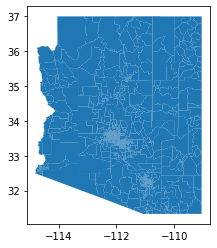

In [49]:
gdf.plot()

**Note that shapefile field names are limited to 10 characters. Check to ensure that all columns are named with fewer than 10 characters.**

In [51]:
os.mkdir('./az_gen_2020_erj')
gdf.to_file('./az_gen_2020_erj/az_gen_2020_erj.shp')

## Insert readme

**Edit as applicable to state-specific processing and fields**

In [80]:
# Define varibales used in readme
fields_dict ={'PRECINCT':'precinct name/identifier from SOS',
              'COUNTY':'county name',
              'COUNTYFP': 'three digit county fips code',
              'SL_DIST':'State Legislative district number - upper and lower districts match',
              'HOR_DIST':'US Representative district number'}
stateabrv = 'AZ'
state = 'Arizona'
year = '2020'
election_type = 'general'
additional_races = 'House of Representatives, US Senate, SLDL, SLDU, Corporation Commissioner and Ballot Measures'
retrieval_date = '07/01/2021'
upload_date = '01/12/2022'
vest_file_link = 'https://dataverse.harvard.edu/file.xhtml?fileId=4864722&version=27.0'
raw_data_source = "[Arizona's Secretary of State website](https://azsos.gov/2020-election-information)"
state_erj_repo = "https://github.com/nonpartisan-redistricting-datahub/erj-az"

def create_fields_table(fields_dict):
    fields_table_data = {'Field Name': list(fields_dict.keys()), 'Description': list(fields_dict.keys())}
    fields_table = pd.DataFrame(fields_table_data)
    return fields_table

#README
def erj_readme_template(fields_dict, stateabrv, state, year, election_type, additional_races, retrieval_date, upload_date, vest_file_link, raw_data_source, state_erj_repo):
    '''Function definitions:
    variables:
    fields_dict = used to create the fields table for the non-standardized/race fields fields. Key is the field/value is the field description
    stateabrv = two character state abbreviation capitalized, 
    state = state name, first letter capitalized, 
    year = election year, 
    election_type = general, primary, special or runoff, 
    additional_races = the races that RDH added to the original vest file (not in VEST's og file), 
    retrieval_date = date RDH retrieved VEST file, 
    upload_date = date RDH uploads ERJ file, 
    vest_file_link = link to dataverse page for VEST's precinct boundary and election results file, 
    raw_data_source = site description and link, 
    state_erj_repo = link to erj github repository for given state
    '''
    #Generalized readme text
    readme_p1 = '''{year} {stateabrv} {election_type} election results

## RDH Date Retrieval
{retrieval_date}

## RDH Upload Date
{upload_date}

## Sources
The RDH retrieved the VEST {year} {election_type} precinct boundary and election results shapefile from [VEST's Harvard Dataverse]({vest_file_link})
The RDH retrieved raw {year} {election_type} election results from {raw_data_source}

## Notes on Field Names:
(adapted from VEST's documentation): 
Columns reporting votes follow the label pattern created by VEST except where noted with an asterisk. 
One example is:
G16PREDCLI
The first character is G for a general election, P for a primary, S for a special, and R for a runoff.
Characters 2 and 3 are the year of the election.*
Characters 4-6 represent the office type (see list below).
Character 7 represents the party of the candidate.
Characters 8-10 are the first three letters of the candidate's last name.

*To fit within the GIS 10 character limit for field names, the naming convention is slightly different for office codes SLL and SLU in at large states.
Year of election is omitted to allow space for the district number. 
One example is:
GSLLD02DAL
The first character is G for a general election, P for a primary, S for a special, and R for a runoff.
Characters 2-4 represent the office type (see list below).
Character 5 represents the party of the candidate.
Characters 6-7 represent the district number of the candidate
Characters 8-10 are the first three letters of the candidate's last name.

Office Codes
A## - Ballot amendment, where ## is an identifier
AGR - Commissioner of Agriculture
ATG - Attorney General
AUD - Auditor
CFO - Chief Financial Officer
CHA - Council Chairman
COC - Corporation Commissioner
COM - Comptroller
CON - State Controller
COU - City Council Member
CSC - Clerk of the Supreme Court
DEL - Delegate to the U.S. House
GOV - Governor
H## - U.S. House, where ## is the district number. AL: at large.
HOD - House of Delegates, accompanied by a HOD_DIST column indicating district number
HOR - U.S. House, accompanied by a HOR_DIST column indicating district number
INS - Insurance Commissioner
LAB - Labor Commissioner
LAN - Commissioner of General Land Office
LND - Commissioner of Public/State Lands
LTG - Lieutenant Governor
MAY - Mayor
MNI - State Mine Inspector
PSC - Public Service Commissioner
PUC - Public Utilities Commissioner
RGT - State University Regent
RRC - Railroad Commissioner
SAC - State Appeals Court (in AL: Civil Appeals)
SBE - State Board of Education
SCC - State Court of Criminal Appeals
SOC - Secretary of Commonwealth
SOS - Secretary of State
SPI - Superintendent of Public Instruction
SPL - Commissioner of School and Public Lands
SSC - State Supreme Court
TAX - Tax Commissioner
TRE - Treasurer
UBR - University Board of Regents/Trustees/Governors
USS - U.S. Senate
SLU - State Legislative Upper District
SLL - State Leglislative Lower District

## Fields:
    '''.format(stateabrv= stateabrv, state= state, year=year, election_type=election_type, additional_races=additional_races,retrieval_date=retrieval_date,
    upload_date=upload_date, vest_file_link=vest_file_link, raw_data_source=raw_data_source, state_erj_repo=state_erj_repo)

    fields_table = create_fields_table(fields_dict)
    readme_p2 = fields_table

    readme_p3='''
    
## Processing Steps
    
The RDH joined additional election results to VEST's existing precinct shapefile, including {additional_races} using Python.
For more information on the processing completed, visit our [Github repository]({state_erj_repo}) for Election Result Joins (ERJ) for {state}.

## Additional Notes

Please contact info@redistrictingdatahub.org for more information.
    '''.format(stateabrv=stateabrv, state=state, year=year, election_type=election_type, additional_races=additional_races, retrieval_date = retrieval_date,
    upload_date = upload_date, vest_file_link = vest_file_link, raw_data_source = raw_data_source, state_erj_repo=state_erj_repo)

    #README concatenation
    full_readme = str(readme_p1)+str(readme_p2)+str(readme_p3)
    print(full_readme)

def export_readme(readme_name, state):
    '''readme_name must include file path to readme within erj folder
    ex: 
    readme_name = './az_gen_2020_erj/readme.txt'
    '''
    with open(readme_name, 'x') as tf:
        tf.write(readme_name)
    print(state, " readme moved to folder")

#Run and create readme - check print to make sure as expected
erj_readme_template(fields_dict=fields_dict, stateabrv= stateabrv, state= state, year=year, election_type=election_type, additional_races=additional_races,retrieval_date=retrieval_date,
    upload_date=upload_date, vest_file_link=vest_file_link, raw_data_source=raw_data_source, state_erj_repo=state_erj_repo)

2020 AZ general election results

## RDH Date Retrieval
07/01/2021

## RDH Upload Date
01/12/2022

## Sources
The RDH retrieved the VEST 2020 general precinct boundary and election results shapefile from [VEST's Harvard Dataverse](https://dataverse.harvard.edu/file.xhtml?fileId=4864722&version=27.0)
The RDH retrieved raw 2020 general election results from [Arizona's Secretary of State website](https://azsos.gov/2020-election-information)

## Notes on Field Names:
(adapted from VEST's documentation): 
Columns reporting votes follow the label pattern created by VEST except where noted with an asterisk. 
One example is:
G16PREDCLI
The first character is G for a general election, P for a primary, S for a special, and R for a runoff.
Characters 2 and 3 are the year of the election.*
Characters 4-6 represent the office type (see list below).
Character 7 represents the party of the candidate.
Characters 8-10 are the first three letters of the candidate's last name.

*To fit within the GIS 10 

**Export readme to erj folder if it looks good!**

In [81]:
export_readme(readme_name, state)

Arizona  readme moved to folder


**Be sure to zip the shapefile with readme, upload to appropriate folder on AWS, and post updated script to Github**